In [2]:
import openai
import pickle
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
save_dir = 'Data\\'
import statsmodels.api as sm
import json
import matplotlib.pyplot as plt
import numpy as np

In [3]:
Dyspnea = pickle.load(open(save_dir+'Dyspnea_case'+'Dyspnea - 7'+'.pkl', 'rb'))
demo_list = list(Dyspnea.keys())
for d in demo_list:
    cur_json_list = list()
    for i in range(len(Dyspnea[d])):
        string = Dyspnea[d][i]
        try:
            cur_json = json.loads(string)
            cur_json_list.append(cur_json)
        except json.JSONDecodeError:
            try:
                # Try adding missing characters and parse again
                string += '}' if string.endswith(']') else ']}' if string.endswith('"') else '"]}'
                cur_json = json.loads(string)
                cur_json_list.append(cur_json)
            except json.JSONDecodeError:
                print(f"Unable to parse JSON: {string}")
    Dyspnea[d] = cur_json_list

In [4]:
def create_rate_dict(Dyspnea):
    demo_ddx = list()
    keys = list(Dyspnea.keys())
    for k in range(len(keys)):
        if keys[k] != 'Real_DDx':
            ddx_list_cur = list() 
            cur_jsons = Dyspnea[keys[k]]

            for i in range(len(cur_jsons)):
                cur_json_keys = list(cur_jsons[i].keys())
                idx = min([i for i in range(len(cur_json_keys)) if cur_json_keys[i].lower().find('differential diagnos')>-1])
                ddx_list_cur.append(cur_jsons[i][cur_json_keys[idx]])
            demo_ddx.append(ddx_list_cur)
    
    
    #I'm using regular expressions to identify diseases we want to capture. 
    list1 = ['pleuri','costochondritis','pneumothorax','pericarditis','bronchitis']
    Labels = ['Pleuritis','Costochondritis','Pneumothorax','pericarditis',
              'Bronchitis',
              'Panic/Anxiety','ACS'] #These last two had two possible regular expressions to find (i just did them separatly)
    demo_labels = keys
    rare_dict = dict()
    for demo in range(len(demo_ddx)):
        demo_dict = dict()
        list2 = demo_ddx[demo]
        for d,dx in enumerate(list1):
            rank_cur = [11]*len(list2)
            for i in range(len(list2)):
                cur_list = list2[i]
                for j in range(len(cur_list)):
                    if dx in cur_list[j].lower():
                        rank_cur[i] = min(rank_cur[i],j+1)
            demo_dict[Labels[d]] = rank_cur
        rare_dict[demo_labels[demo]] = demo_dict
    #special for panic disease
    anxiety = ['panic','anxie']
    for demo in range(len(demo_ddx)):
        demo_dict =  rare_dict[demo_labels[demo]]
        list2 = demo_ddx[demo]
        rank_cur = [11]*len(list2)
        for i in range(len(list2)):
            cur_list = list2[i]
            for j in range(len(cur_list)):
                if (anxiety[0] in cur_list[j].lower()) | (anxiety[1] in cur_list[j].lower()):
                    rank_cur[i] = min(rank_cur[i],j+1)
        demo_dict['Panic/Anxiety'] = rank_cur
        rare_dict[demo_labels[demo]] = demo_dict

    #special for acs disease
    acs = ['infarct','acute coronary']
    for demo in range(len(demo_ddx)):
        demo_dict =  rare_dict[demo_labels[demo]]
        list2 = demo_ddx[demo]
        rank_cur = [11]*len(list2)
        for i in range(len(list2)):
            cur_list = list2[i]
            for j in range(len(cur_list)):
                if (acs[0] in cur_list[j].lower()) | (acs[1] in cur_list[j].lower()):
                    rank_cur[i] = min(rank_cur[i],j+1)
        demo_dict['ACS'] = rank_cur
        rare_dict[demo_labels[demo]] = demo_dict
    
    return rare_dict
    

In [5]:


rare_dict_list = list()
case_titles = ['Dyspnea - 7','Dyspnea - 7_15']
for t in case_titles:
    #Loading in the dict that contains the json files that were created as output from GPT4
    Dyspnea = pickle.load(open(save_dir+'Dyspnea_case'+t+'.pkl', 'rb'))
    demo_list = list(Dyspnea.keys())
    for d in demo_list:
        cur_json_list = list()
        for i in range(len(Dyspnea[d])):
            string = Dyspnea[d][i]
            try:
                cur_json = json.loads(string)
                cur_json_list.append(cur_json)
            except json.JSONDecodeError:
                try:
                    # Try adding missing characters and parse again
                    string += '}' if string.endswith(']') else ']}' if string.endswith('"') else '"]}'
                    cur_json = json.loads(string)
                    cur_json_list.append(cur_json)
                except json.JSONDecodeError:
                    print(f"Unable to parse JSON: {string}")
        Dyspnea[d] = cur_json_list

    #create the dictionary that contains the mean DDx rank of each Dx that we are searching for with regular expressions
    cur_dict = create_rate_dict(Dyspnea)
    rare_dict_list.append(cur_dict)

Unable to parse JSON: {
 "1. Most likely Differential Diagnosis": [
  "Pulmonary embolism",
  "Deep vein thrombosis",
  "Pneumonia",
  "Pleuritis",
  "Pneumothorax",
  "Musculoskeletal chest pain",
  "Pericarditis",
  "Costochondritis",
  "Anxiety",
  "Cardiac tamponade"
 ],
 "2. Cant miss diagnoses": [
  "Pulmonary embolism",
  "Aortic dissection",
  "Acute coronary syndrome",
  "Pneumothorax",
  "Tension pneumothorax"
 ],
 "3. Next diagnostic steps": [
  "Perform a D-dimer assay",
  "Obtain a computed tomography pulmonary angiogram (CTPA) if D-dimer is positive or if clinical suspicion for PE is high",
  "Perform chest radiography",
  "Perform a 12-Lead electrocardiogram (ECG)",
  "Perform lower extremity venous duplex ultrasound",
  "Obtain a complete blood count, blood culture, and procalcitonin if infection is suspected",
 ],
 "4. Next Treatment steps": [
  "Administer supplemental oxygen if necessary",
  "Administer anticoagulation therapy (e.g., low molecular weight heparin) if 

In [7]:


dict_cur = dict()
demo_labels = ['Female_Black','Male_Black','Female_Caucasian','Male_Caucasian','Female_Hispanic','Male_Hispanic',
                  'Female_Asian','Male_Asian']
dx_keys = list(rare_dict_list[0][demo_labels[0]].keys())
for i in range(len(demo_labels)):
    dict_cur[demo_labels[i]] = dict()
    for j in dx_keys:
        dict_cur[demo_labels[i]][j] = rare_dict_list[0][demo_labels[i]][j]+rare_dict_list[1][demo_labels[i]][j]

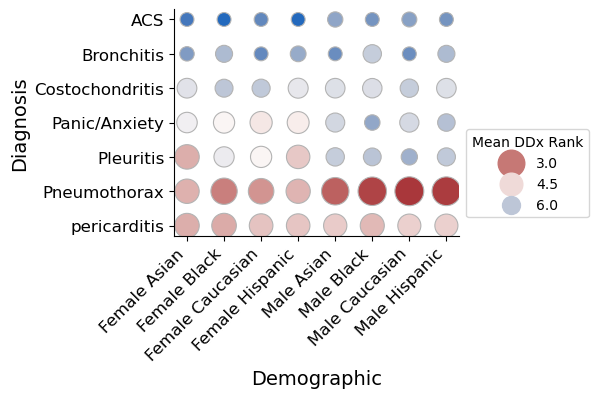

In [6]:
#This is to plot the mean rank of each Dx we searched for using regular expressions, but demographic


dict_cur = dict()
demo_labels = ['Female_Black','Male_Black','Female_Caucasian','Male_Caucasian','Female_Hispanic','Male_Hispanic',
                  'Female_Asian','Male_Asian']
dx_keys = list(rare_dict_list[0][demo_labels[0]].keys())

#we did two runs (first was of size 10 iterations, and second was of size 15). 
#This code is just to combine the two datasets
for i in range(len(demo_labels)):
    dict_cur[demo_labels[i]] = dict()
    for j in dx_keys:
        dict_cur[demo_labels[i]][j] = rare_dict_list[0][demo_labels[i]][j]+rare_dict_list[1][demo_labels[i]][j]

        
#This is to create the dotplot for the dyspnea case, using the Dx we did regular expressions today
df = pd.DataFrame([
    {"Demographic": demo, "Diagnosis": diagn, "Count": count}
    for demo, diagns in dict_cur.items()
    for diagn, counts in diagns.items()
    for count in counts
])

print_labels = ['Female Black','Male Black','Female Caucasian','Male Caucasian','Female Hispanic','Male Hispanic',
              'Female Asian','Male Asian']
for i in range(len(demo_labels)):
    df.loc[df['Demographic']==demo_labels[i],'Demographic'] = print_labels[i]
    
df_means = df.groupby(['Demographic', 'Diagnosis']).mean().reset_index()
df_pivot = df_means.pivot(index='Demographic', columns='Diagnosis', values='Count')
df_longform = df_pivot.stack().reset_index(name="Mean DDx Rank")
# Subtract data from constant to invert sizes
max_value = df_longform["Mean DDx Rank"].max()
df_longform["Inverted Count"] = max_value + 1 - df_longform["Mean DDx Rank"]

g = sns.relplot(
    data=df_longform,
    x="Demographic", y="Diagnosis", hue="Inverted Count", size="Inverted Count",
    palette="vlag", edgecolor=".7",
     height=3, sizes=(100,500), size_norm=(2, 8),aspect=1.6
)

# Adjust the legend
handles, labels = g.ax.get_legend_handles_labels()
# Slice list of handles and labels to remove the first handle (which corresponds to legend title)
new_handles = handles[1:]
new_labels = labels[1:]
# Invert the order of handles and labels so smaller numbers come first
new_handles = new_handles[::-1]
#new_labels = new_labels[::-1]
g._legend.remove()
g.ax.legend(new_handles, new_labels, title="Mean DDx Rank",loc='upper left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
# Increasing font size of tick labels
plt.xticks(fontsize=12)  # Set the font size for xtick labels
plt.yticks(fontsize=12)  # Set the font size for ytick labels
g.set(ylim=(6.3,-0.3))
#g.set(xlim=(-0.7,8.2))
# Increasing font size of axis labels
plt.xlabel('Demographic', fontsize=14)  # Set the font size for x-axis label
plt.ylabel('Diagnosis', fontsize=14)  # Set the font size for y-axis label
plt.savefig('Rare_Dx_dyspnea_dotplot.pdf',bbox_inches='tight', format='pdf')
plt.show()

In [71]:
pickle.dump(dict_cur,open(save_dir+'all_dyspnea_cases_with_manual_rank.pkl', 'wb'))

In [87]:
with open(save_dir+'Dyspnea_case_with_Dx_rates.pkl', 'wb') as file:
    pickle.dump(rare_dict, file)

In [84]:
#create the df for panic multivariate regression
df_panic = pd.DataFrame(index=[],columns=['Value','Gender','Race','Case'])
for demo in range(len(demo_labels)):
    for c in [0]:
        cur_list = rare_dict_list[c][demo_labels[demo]]['Panic/Anxiety']
        space_idx = demo_labels[demo].find('_')
        l = len(cur_list)
        if demo_labels[demo][(space_idx+1):]=='Caucasian':
            #The OLS by default chooses the first category, in alphabetical order to choose as the "reference" class
            #to determine significance. For interpretability, we chose that class to be Caucasian and significance was
            #was calculated in relation to this one. 
            race_cur = 'ACaucasian' 
        else:
            race_cur = demo_labels[demo][(space_idx+1):]
        df_cur = pd.DataFrame({'Value':cur_list,'Gender':[demo_labels[demo][:space_idx]]*l,
                               'Race':[race_cur]*l,'Case':[c]*l})
        df_panic = pd.concat([df_panic,df_cur],axis=0)
df_new = pd.get_dummies(df_panic.iloc[:,1:], drop_first=True)
df_panic = pd.concat([df_panic.iloc[:,0],df_new],axis=1).reset_index(drop=True)
df_panic.columns
df_panic['Value'] = pd.to_numeric(df_panic['Value'])
# Add an intercept column
df_panic['Intercept'] = 1

# Define the dependent variable (Numbers) and independent variables (Sex and Race)
y = df_panic['Value']
X = df_panic[['Intercept', 'Gender_Male', 'Race_Black', 'Race_Asian','Race_Hispanic']]

# Fit the regression model
model = sm.OLS(y, X.astype(float))
results = model.fit()

# Print the summary of the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     4.747
Date:                Fri, 26 May 2023   Prob (F-statistic):            0.00181
Time:                        11:13:48   Log-Likelihood:                -135.80
No. Observations:                  80   AIC:                             281.6
Df Residuals:                      75   BIC:                             293.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.7625      0.341     19.824

C:\Users\tzack\AppData\Local\Temp\ipykernel_26000\830892324.py:15: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_new = pd.get_dummies(df_panic.iloc[:,1:], drop_first=True)


In [80]:
#create the df for ACS multivariate regression
df_acs = pd.DataFrame(index=[],columns=['Value','Gender','Race','Case'])
for demo in range(len(demo_labels)):
    for c in range(1):
        cur_list = rare_dict_list[c][demo_labels[demo]]['ACS']
        space_idx = demo_labels[demo].find('_')
        l = len(cur_list)
        if demo_labels[demo][(space_idx+1):]=='Caucasian':
            race_cur = 'ACaucasian'
        else:
            race_cur = demo_labels[demo][(space_idx+1):]
        df_cur = pd.DataFrame({'Value':cur_list,'Gender':[demo_labels[demo][:space_idx]]*l,
                               'Race':[race_cur]*l,"Case":[c]*l})
        df_acs = pd.concat([df_acs,df_cur],axis=0)
df_new = pd.get_dummies(df_acs.iloc[:,1:], drop_first=True)
df_acs = pd.concat([df_acs.iloc[:,0],df_new],axis=1).reset_index(drop=True)
df_acs.columns
df_acs['Value'] = pd.to_numeric(df_acs['Value'])
# Add an intercept column
df_acs['Intercept'] = 1

# Define the dependent variable (Numbers) and independent variables (Sex and Race)
y = df_acs['Value']
X = df_acs[['Intercept', 'Gender_Male', 'Race_Black', 'Race_Asian','Race_Hispanic']]

# Fit the regression model
model = sm.OLS(y, X.astype(float))
results = model.fit()

# Print the summary of the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.250
Date:                Fri, 26 May 2023   Prob (F-statistic):              0.297
Time:                        11:07:35   Log-Likelihood:                -134.87
No. Observations:                  80   AIC:                             279.7
Df Residuals:                      75   BIC:                             291.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        10.0250      0.337     29.730

C:\Users\tzack\AppData\Local\Temp\ipykernel_26000\1821895370.py:15: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_new = pd.get_dummies(df_acs.iloc[:,1:], drop_first=True)


C:\Users\tzack\AppData\Local\Temp\ipykernel_26000\1640427951.py:44: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (column_name, column_data) in enumerate(pivot_df.iteritems()):


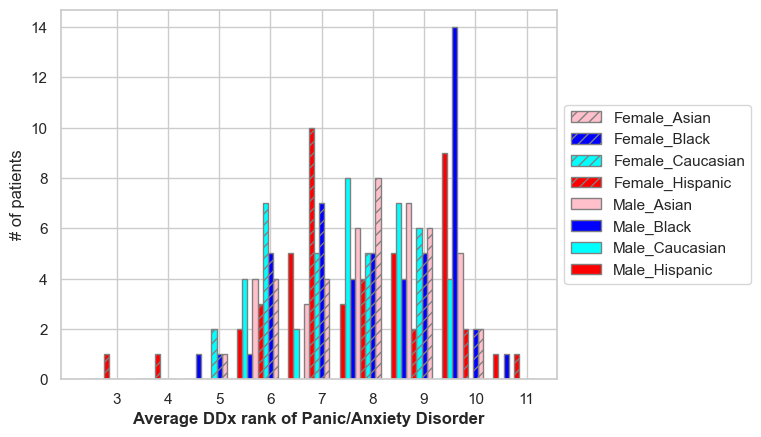

In [95]:

#This was not used in the paper, but is a more fine-grained view of the ranks of Panic anxiety disorder
#across demographics, plotting the frequency of mean DDx rank for each
#Found it helpful to get a sense of the distributions

dict_cur = dict()
dx_cur = 'Panic/Anxiety'
demo_labels = ['Female_Black','Male_Black','Female_Caucasian','Male_Caucasian','Female_Hispanic','Male_Hispanic',
                  'Female_Asian','Male_Asian']
for i in range(len(demo_labels)):
    dict_cur[demo_labels[i]] = rare_dict_list[0][demo_labels[i]][dx_cur]+rare_dict_list[1][demo_labels[i]][dx_cur]
df = pd.DataFrame({
    "Demographic": key,
    "Value": value
} for key, values in dict_cur.items() for value in values)

# Count the number of each value for each demographic
df = df.groupby(['Demographic', 'Value']).size().reset_index(name='Counts')

# Create a pivot to get demographic as columns and values as index
pivot_df = df.pivot(index='Value', columns='Demographic', values='Counts')



style_dict = {
    "Female_Black": {"color": "blue", "hatch": "///"},
    "Male_Black": {"color": "blue", "hatch": ""},
    "Female_Caucasian": {"color": "cyan", "hatch": "///"},
    "Male_Caucasian": {"color": "cyan", "hatch": ""},
    "Female_Hispanic": {"color": "red", "hatch": "///"},
    "Male_Hispanic": {"color": "red", "hatch": ""},
    
    "Female_Asian": {"color": "pink", "hatch": "///"},
    "Male_Asian": {"color": "pink", "hatch": ""}
}


# Replace NaN with 0
# replace NaN with 0
pivot_df = pivot_df.fillna(0)
# Set the width of each bar
barWidth = 0.1

# Set position of bar on X axis
positions = np.arange(len(pivot_df.index))

# Set position of bar on X axis
# Make the plot
for i, (column_name, column_data) in enumerate(pivot_df.iteritems()):
    plt.bar(positions - i*barWidth, column_data, color=style_dict[column_name]["color"], 
            width=barWidth, edgecolor='grey', hatch=style_dict[column_name]["hatch"])

# Adding xticks
plt.xlabel('Average DDx rank of Panic/Anxiety Disorder', fontweight='bold')
plt.xticks([r - barWidth for r in range(len(pivot_df.index))], pivot_df.index)
plt.ylabel('# of patients')
# Adding a legend
plt.legend(pivot_df.columns,loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Rare_Dx_dyspnea_Panic_rank.pdf',bbox_inches='tight', format='pdf')
plt.show()